# Gaussian Mixture Model (GMM)
## Definition
A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions. One can think of mixture models as generalizing $k$-means clustering to incorporate information about the covariance structure of the data of each class. (K-means can be thought of having spherical covariances.) By using a sufficient number of Gaussians, and adjusting the

1. means
1. covariances
1. linear combination weights

almost any continuous density can be approximated. Given a data vector $\mathbf{x}$ and $K$ Gaussians / classes, we can write

$$p(\mathbf{x}) = \sum_{k=1}^K \pi_{k} \mathcal{N}(\mathbf{x} | \boldsymbol{\mu_{k}}, \boldsymbol{\Sigma_{k}})$$

where each Gaussian density is called a *component* of the mixture and has its own mean and covariance. The parameters $\pi_k$ are called the *mixing coefficients*, with $\sum_{k=1}^K \pi_k = 1$ and $0 \le \pi_k \le 1$. They can also be viewed as the class priors $\pi_k = p(k)$.

The posterior probabilities are given by

$$p(k | \mathbf{x}) = 
\frac{p(k)p(\mathbf{x}|k)}
{\sum_{l=1}^K p(l)p(\mathbf{x}|l)} = 
\frac{\pi_k \mathcal{N}(\mathbf{x} | \boldsymbol{\mu_{k}}, \boldsymbol{\Sigma_{k}})}
{\sum_{l=1}^K \pi_l \mathcal{N}(\mathbf{x} | \boldsymbol{\mu_{l}}, \boldsymbol{\Sigma_{l}})}$$

The model parameters are thus specified by $\lambda = \boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Sigma}$. The maximum likelihood solution has no closed-form analytical solution, and Expectation Maximization is used for optimization.

## Implementation
`scikit-learn` provides GMM implementations:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.mixture import GaussianMixture

## Unsupervised learning: clustering

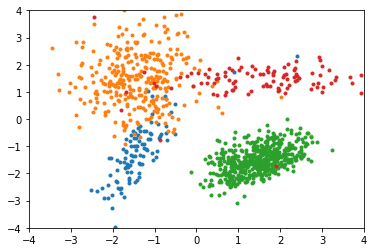

In [2]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000, 
                           n_features=2, 
                           n_informative=2,
                           n_redundant=0,
                           n_repeated=0,
                           n_classes=4,  # vary this
                           n_clusters_per_class=1,
                           weights=[0.1, 0.3, 0.5, 0.1],
                           class_sep=1.5)  # vary this
for k in set(y):
    plt.plot(X[y==k,0], X[y==k,1], '.')
plt.axis([-4, 4, -4, 4]);

priors: [ 0.49994695  0.28267767  0.0970013   0.12037408]
score: -2.912971962110656


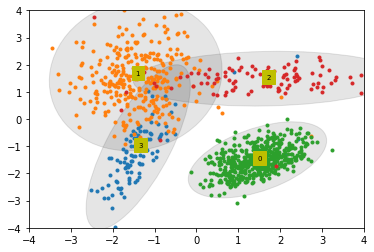

In [3]:
K = 4  # try different settings here
gmm = GaussianMixture(n_components=K,   
                      covariance_type='full')  # full | diag | spherical | tied
gmm.fit(X)
print(f"priors: {gmm.weights_}")
print(f"score: {gmm.score(X)}")

def draw_ellipses(gmm):
    from matplotlib.patches import Ellipse
    for k in range(gmm.n_components):
        t = gmm.covariance_type
        if t == 'full':
            c = gmm.covariances_[k][:2, :2]
        elif t == 'tied':
            c = gmm.covariances_[:2, :2]
        elif t == 'diag':
            c = np.diag(gmm.covariances_[k][:2])
        elif t == 'spherical':
            c = np.eye(gmm.means_.shape[1]) * gmm.covariances_[k]
        v, w = np.linalg.eigh(c)
        u = w[0] / np.linalg.norm(w[0])
        angle = 180 * np.arctan2(u[1], u[0]) / np.pi  # in degrees
        radius = 2 * np.sqrt(2. * v) * 2  # 2 stdev = %95
        xy = gmm.means_[k, :2]
        plt.text(xy[0], xy[1], k, size=7, backgroundcolor='y')
        ell = Ellipse(xy, radius[0], radius[1], 180 + angle, alpha=0.1, color='k')
        plt.gca().add_artist(ell)

for k in set(y):
    plt.plot(X[y==k,0], X[y==k,1], '.')
draw_ellipses(gmm)
plt.axis([-4, 4, -4, 4]);

Let's create a line that slices through the data and see what the posterior probabilities are for points on the line:

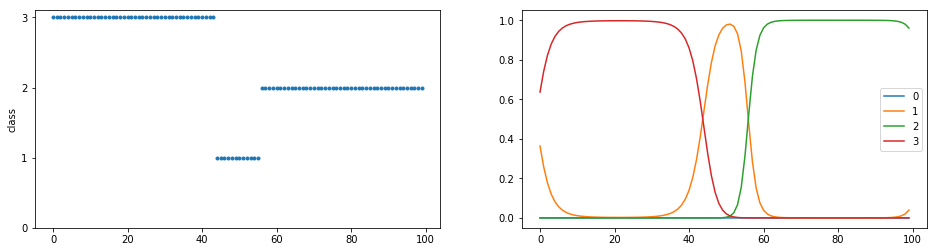

In [4]:
L = np.c_[np.linspace(-4, 4, 100), 
          np.linspace(-4, 4, 100)]

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
H = gmm.predict(L)
plt.plot(H, '.');
plt.ylabel('class')
plt.yticks(range(len(set(y))))

plt.subplot(1,2,2)
H = gmm.predict_proba(L)
plt.plot(H);
plt.legend(range(4));

The fitting algorithm is called *Expectation-Maximization* (EM). It alternates between the E-step and the M-step, until the solution does not improve beyond a pre-determined threshold. For GMMs, the E-step calculates the posterior probabilities given the current model parameters. Then, in the M-step, the model parameters are updated given the posterior probabilities.

Let's watch it in action:

In [5]:
from matplotlib import animation

K = 4
gmm = GaussianMixture(n_components=K,  # try different settings here
                       covariance_type='full',  # full | diag | spherical | tied
                       warm_start=True, max_iter=1)

    
FFMpegWriter = animation.writers['ffmpeg']
writer = FFMpegWriter(fps=10)
fig = plt.figure()
with writer.saving(fig, "gmm.mp4", 100):
    for i in range(50):
        gmm.fit(X)
        plt.clf()
        for k in range(K):
            plt.plot(X[y==k,0], X[y==k,1], '.')
        draw_ellipses(gmm)
        writer.grab_frame()
plt.close()

import io
import base64
from IPython.display import HTML  
video = io.open('gmm.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video autoplay=1 alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

/Users/kain/miniconda3/lib/python3.6/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


One can now generate more samples from the fitted distribution:

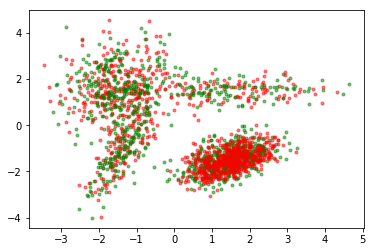

In [6]:
X2, y2 = gmm.sample(1000)

for k in set(y):
    plt.plot(X [y ==k,0], X [y ==k,1], '.', alpha=0.5, color='r')  # old data
    plt.plot(X2[y2==k,0], X2[y2==k,1], '.', alpha=0.5, color='g')  # new data

## Supervised learning: classification
Supervised learning can be achieved by setting the priors manually, and fitting a normal distribution to each mean and covariance component manually.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
  train_test_split(X, y, 
                   test_size=0.5,
                   shuffle=True)

gmm = GaussianMixture(n_components=3, covariance_type='full')  # try different settings here
gmm.fit(X_train)  # really just to create covariance objects, which we will then override
gmm.weights = np.array([.1, .3, .6])
for k in range(3):
    data = X_train[y_train == k]  # data per component
    gmm.means_[k]       = np.mean(data, axis=0)
    gmm.covariances_[k] = np.cov(data, rowvar=0)

In [8]:
from sklearn.metrics import accuracy_score

y_test_hat = gmm.predict(X_test)
accuracy_score(y_test_hat, y_test)

0.86199999999999999

## Supervised learning: regression
When a GMM represents the *joint density* of two distributions, we can use it for mapping. Let 

$$\mathbf{Z} = \begin{bmatrix}
\mathbf{X} \\
\mathbf{Y}
\end{bmatrix}
$$

and thus the joint-density GMM (JDGMM) parameters are (for any one component):

$$\boldsymbol{\mu} = \begin{bmatrix}
\boldsymbol{\mu}^x \\
\boldsymbol{\mu}^y
\end{bmatrix}
$$

and

$$\boldsymbol{\varSigma} = \begin{bmatrix}
\boldsymbol{\varSigma}^{xx} & \boldsymbol{\varSigma}^{yx}\\
\boldsymbol{\varSigma}^{xy} & \boldsymbol{\varSigma}^{yy}
\end{bmatrix}.
$$

After fitting to the joint data, the regression function is implemented as a probabilistic mixture of linear transformations:

$${\cal F}(\mathbf{x}) = \sum_{k=1}^{K} p(k|\mathbf{x}) \cdot (\mathbf{W}_{k} \mathbf{x}+\mathbf{b}_{k})$$

with

$$\mathbf{W}_k = \boldsymbol{\varSigma}_{k}^{xy} {\boldsymbol{\varSigma}_{k}^{xx}}^{-1}$$

and

$$\mathbf{b}_k = \boldsymbol{\mu}_k^y - \mathbf{W}_k \boldsymbol{\mu}_k^x.$$

Let us consider an example:

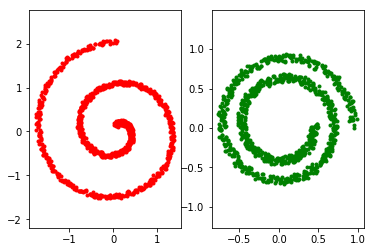

In [9]:
def generate_spirals(N=1000):
    t = np.linspace(0, 2.0, N) * 2 * np.pi
    r = np.linspace(2, .1, N)
    X = np.c_[-r * np.sin(t), r * np.cos(t)]
    r = np.linspace(0.9, .4, N)
    Y = np.c_[r * np.cos(t), r * np.sin(t)]
    
    X += np.random.rand(N, 2) * 0.1  # add noise
    Y += np.random.rand(N, 2) * 0.1  # add noise
    return X, Y

X_train, Y_train = generate_spirals()
X_test,  Y_test  = generate_spirals()

plt.subplot(121)
plt.plot(X_train[:,0], X_train[:,1], 'r.')
plt.axis('equal')
plt.subplot(122)
plt.plot(Y_train[:,0], Y_train[:,1], 'g.')
plt.axis('equal');

In [10]:
class JDGMM(object):
    "Joint-Density Gaussian Mixture Model for regression"
    def fit(self, X, Y, K):
        self.xd = xd = X.shape[1]  # dimensionality of features
        self.yd = yd = Y.shape[1]
        # create and model the joint distribution
        Z = np.hstack((X, Y))
        gmmZ = GaussianMixture(n_components=K, max_iter=10_000)
        gmmZ.fit(Z)
        # create the associated GMM for X
        self.gmmX = gmmX = GaussianMixture(n_components=K)
        gmmX.fit(X)  # really just to create covariance objects, which we will then override
        gmmX.weights_     = gmmZ.weights_
        gmmX.means_       = gmmZ.means_[:,:xd]
        gmmX.covariances_ = gmmZ.covariances_[:,:xd,:xd]
        # create gmmY purely for visualization purposes
        self.gmmY = gmmY = GaussianMixture(n_components=K)
        gmmY.fit(Y)  # really just to create covariance objects, which we will then override
        gmmY.weights_     = gmmZ.weights_
        gmmY.means_       = gmmZ.means_[:,xd:]
        gmmY.covariances_ = gmmZ.covariances_[:,xd:,xd:]
        # regression
        self.W = np.empty((K, xd, yd))
        self.b = np.empty((K, yd))
        for k in range(K):
            Sigma = gmmZ.covariances_[k]
            self.W[k] = W = np.linalg.solve(Sigma[:xd,:xd], Sigma[xd:,:xd].T)
            self.b[k] = gmmZ.means_[k,xd:] - gmmZ.means_[k,:xd] @ W
                    
    def predict(self, X):
        Y = np.zeros((len(X), self.yd))
        H = self.gmmX.predict_proba(X)
        for k in range(self.gmmX.n_components):
            Y += (H[:,k] * (X @ self.W[k] + self.b[k]).T).T  # probabilistically mixing together linear transforms
        return Y

Let's see how the components were allocated:

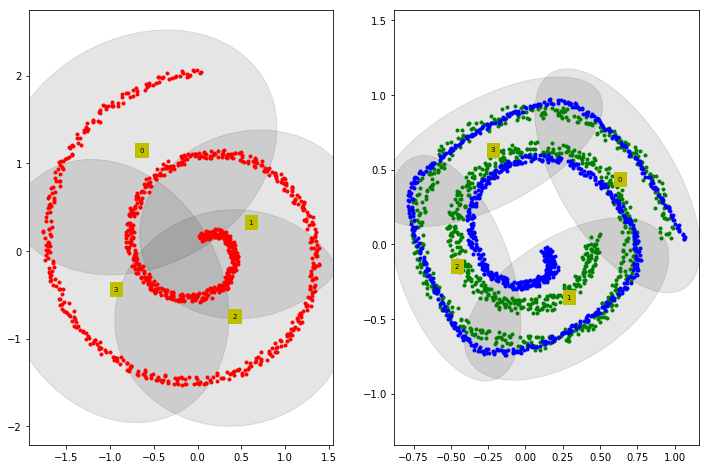

In [11]:
jdgmm = JDGMM()
jdgmm.fit(X_train, Y_train, 4)  # play with the number of components here, 1-32
Y_test_hat = jdgmm.predict(X_test)

plt.figure(figsize=(12,8))
plt.subplot(121)
plt.plot(X_test[:,0], X_test[:,1], 'r.')
draw_ellipses(jdgmm.gmmX)
plt.axis('equal')
plt.subplot(122)
plt.plot(Y_test[:,0], Y_test[:,1], 'g.')
plt.plot(Y_test_hat[:,0], Y_test_hat[:,1], 'b.')
draw_ellipses(jdgmm.gmmY)
plt.axis('equal');

Let's look at what happens when we *also* map a grid:

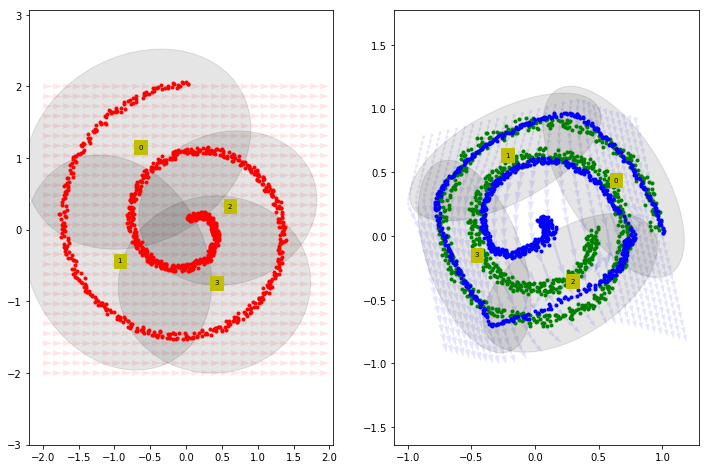

In [12]:
jdgmm.fit(X_train, Y_train, 4)  # vary the number of components here
Y_test_hat = jdgmm.predict(X_test)

n = 30
xx, yy = np.meshgrid(np.linspace(-2, 2, n),
                     np.linspace(-2, 2, n))
X_grid = np.c_[xx.flat, yy.flat]
Y_grid_hat = jdgmm.predict(X_grid)

def draw_grid(M, **kargs):
    def arrows(x, y, **kargs):
        """draw arrows in Z-plane for a complex sequence"""
        plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1, **kargs)
    for m in np.split(M, n):
        #plt.plot(m[:,0], m[:,1], '.-', **kargs)   
        arrows(m[:,0], m[:,1], **kargs)

plt.figure(figsize=(12,8))
plt.subplot(121)
plt.plot(X_test[:,0], X_test[:,1], 'r.')
draw_ellipses(jdgmm.gmmX)
draw_grid(X_grid, color='r', alpha=0.1)
plt.axis('equal')
plt.subplot(122)
plt.plot(Y_test[:,0], Y_test[:,1], 'g.')
plt.plot(Y_test_hat[:,0], Y_test_hat[:,1], 'b.')
draw_ellipses(jdgmm.gmmY)
draw_grid(Y_grid_hat, color='b', alpha=0.1)
plt.axis('equal');

Note that the predicted trajectory is continuous, unless $K$ is set too high.

`scikit-learn` offers a variant of the standard GMM known as `BayesianGaussianMixture`. For more information, see http://scikit-learn.org/stable/modules/mixture.html#variational-bayesian-gaussian-mixture.